In [1]:
#https://towardsdatascience.com/denoising-autoencoders-dae-how-to-use-neural-networks-to-clean-up-your-data-cd9c19bc6915
import sys, os
sys.path.append("./dataset")
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
import pickle
from dataset.mnist import load_mnist

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [6]:
# Specify how much noise to add
level_of_noise=0.5

# Add random noise based on sampling from Gaussian distribution
X_train_noisy = X_train + level_of_noise * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + level_of_noise * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)

# Enforce min-max boundaries so it does not go beyond [0,1] range
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

In [7]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

X_train_noisy = X_train_noisy.reshape(60000, 784)
X_test_noisy = X_test_noisy.reshape(10000, 784)

In [8]:
from tensorflow import keras
from keras.models import Model # for creating a Neural Network Autoencoder model
from keras import Input # for instantiating a keras tensor
from keras.layers import Dense, LeakyReLU, BatchNormalization # for adding layers to DAE model
from tensorflow.keras.utils import plot_model # for plotting model diagram
main_dir=os.path.dirname(sys.path[0])

In [9]:
#--- Define Shapes
n_inputs=X_train.shape[1] # number of input neurons = the number of features X_train

#--- Input Layer 
visible = Input(shape=(n_inputs,), name='Input-Layer') # Specify input shape

#--- Encoder Layer
e = Dense(units=n_inputs, name='Encoder-Layer')(visible)
e = BatchNormalization(name='Encoder-Layer-Normalization')(e)
e = LeakyReLU(name='Encoder-Layer-Activation')(e)

#--- Middle Layer
middle = Dense(units=n_inputs, activation='linear', activity_regularizer=keras.regularizers.L1(0.0001), name='Middle-Hidden-Layer')(e)

#--- Decoder Layer
d = Dense(units=n_inputs, name='Decoder-Layer')(middle)
d = BatchNormalization(name='Decoder-Layer-Normalization')(d)
d = LeakyReLU(name='Decoder-Layer-Activation')(d)

#--- Output layer
output = Dense(units=n_inputs, activation='sigmoid', name='Output-Layer')(d)

# Define denoising autoencoder model
model = Model(inputs=visible, outputs=output, name='Denoising-Autoencoder-Model')

# Compile denoising autoencoder model
model.compile(optimizer='adam', loss='mse')

In [10]:
# Print model summary
print(model.summary())

Model: "Denoising-Autoencoder-Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input-Layer (InputLayer)     [(None, 784)]             0         
_________________________________________________________________
Encoder-Layer (Dense)        (None, 784)               615440    
_________________________________________________________________
Encoder-Layer-Normalization  (None, 784)               3136      
_________________________________________________________________
Encoder-Layer-Activation (Le (None, 784)               0         
_________________________________________________________________
Middle-Hidden-Layer (Dense)  (None, 784)               615440    
_________________________________________________________________
Decoder-Layer (Dense)        (None, 784)               615440    
_________________________________________________________________
Decoder-Layer-Normalization  (None, 784

In [11]:
# Plot the denoising autoencoder model diagram
plot_model(model, to_file=main_dir+'/pics/Denoising_Autoencoder.png', show_shapes=True, dpi=300)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


Epoch 1/3
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0155 - val_loss: 0.0183
Epoch 2/3
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0149 - val_loss: 0.0151
Epoch 3/3
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0145 - val_loss: 0.0160


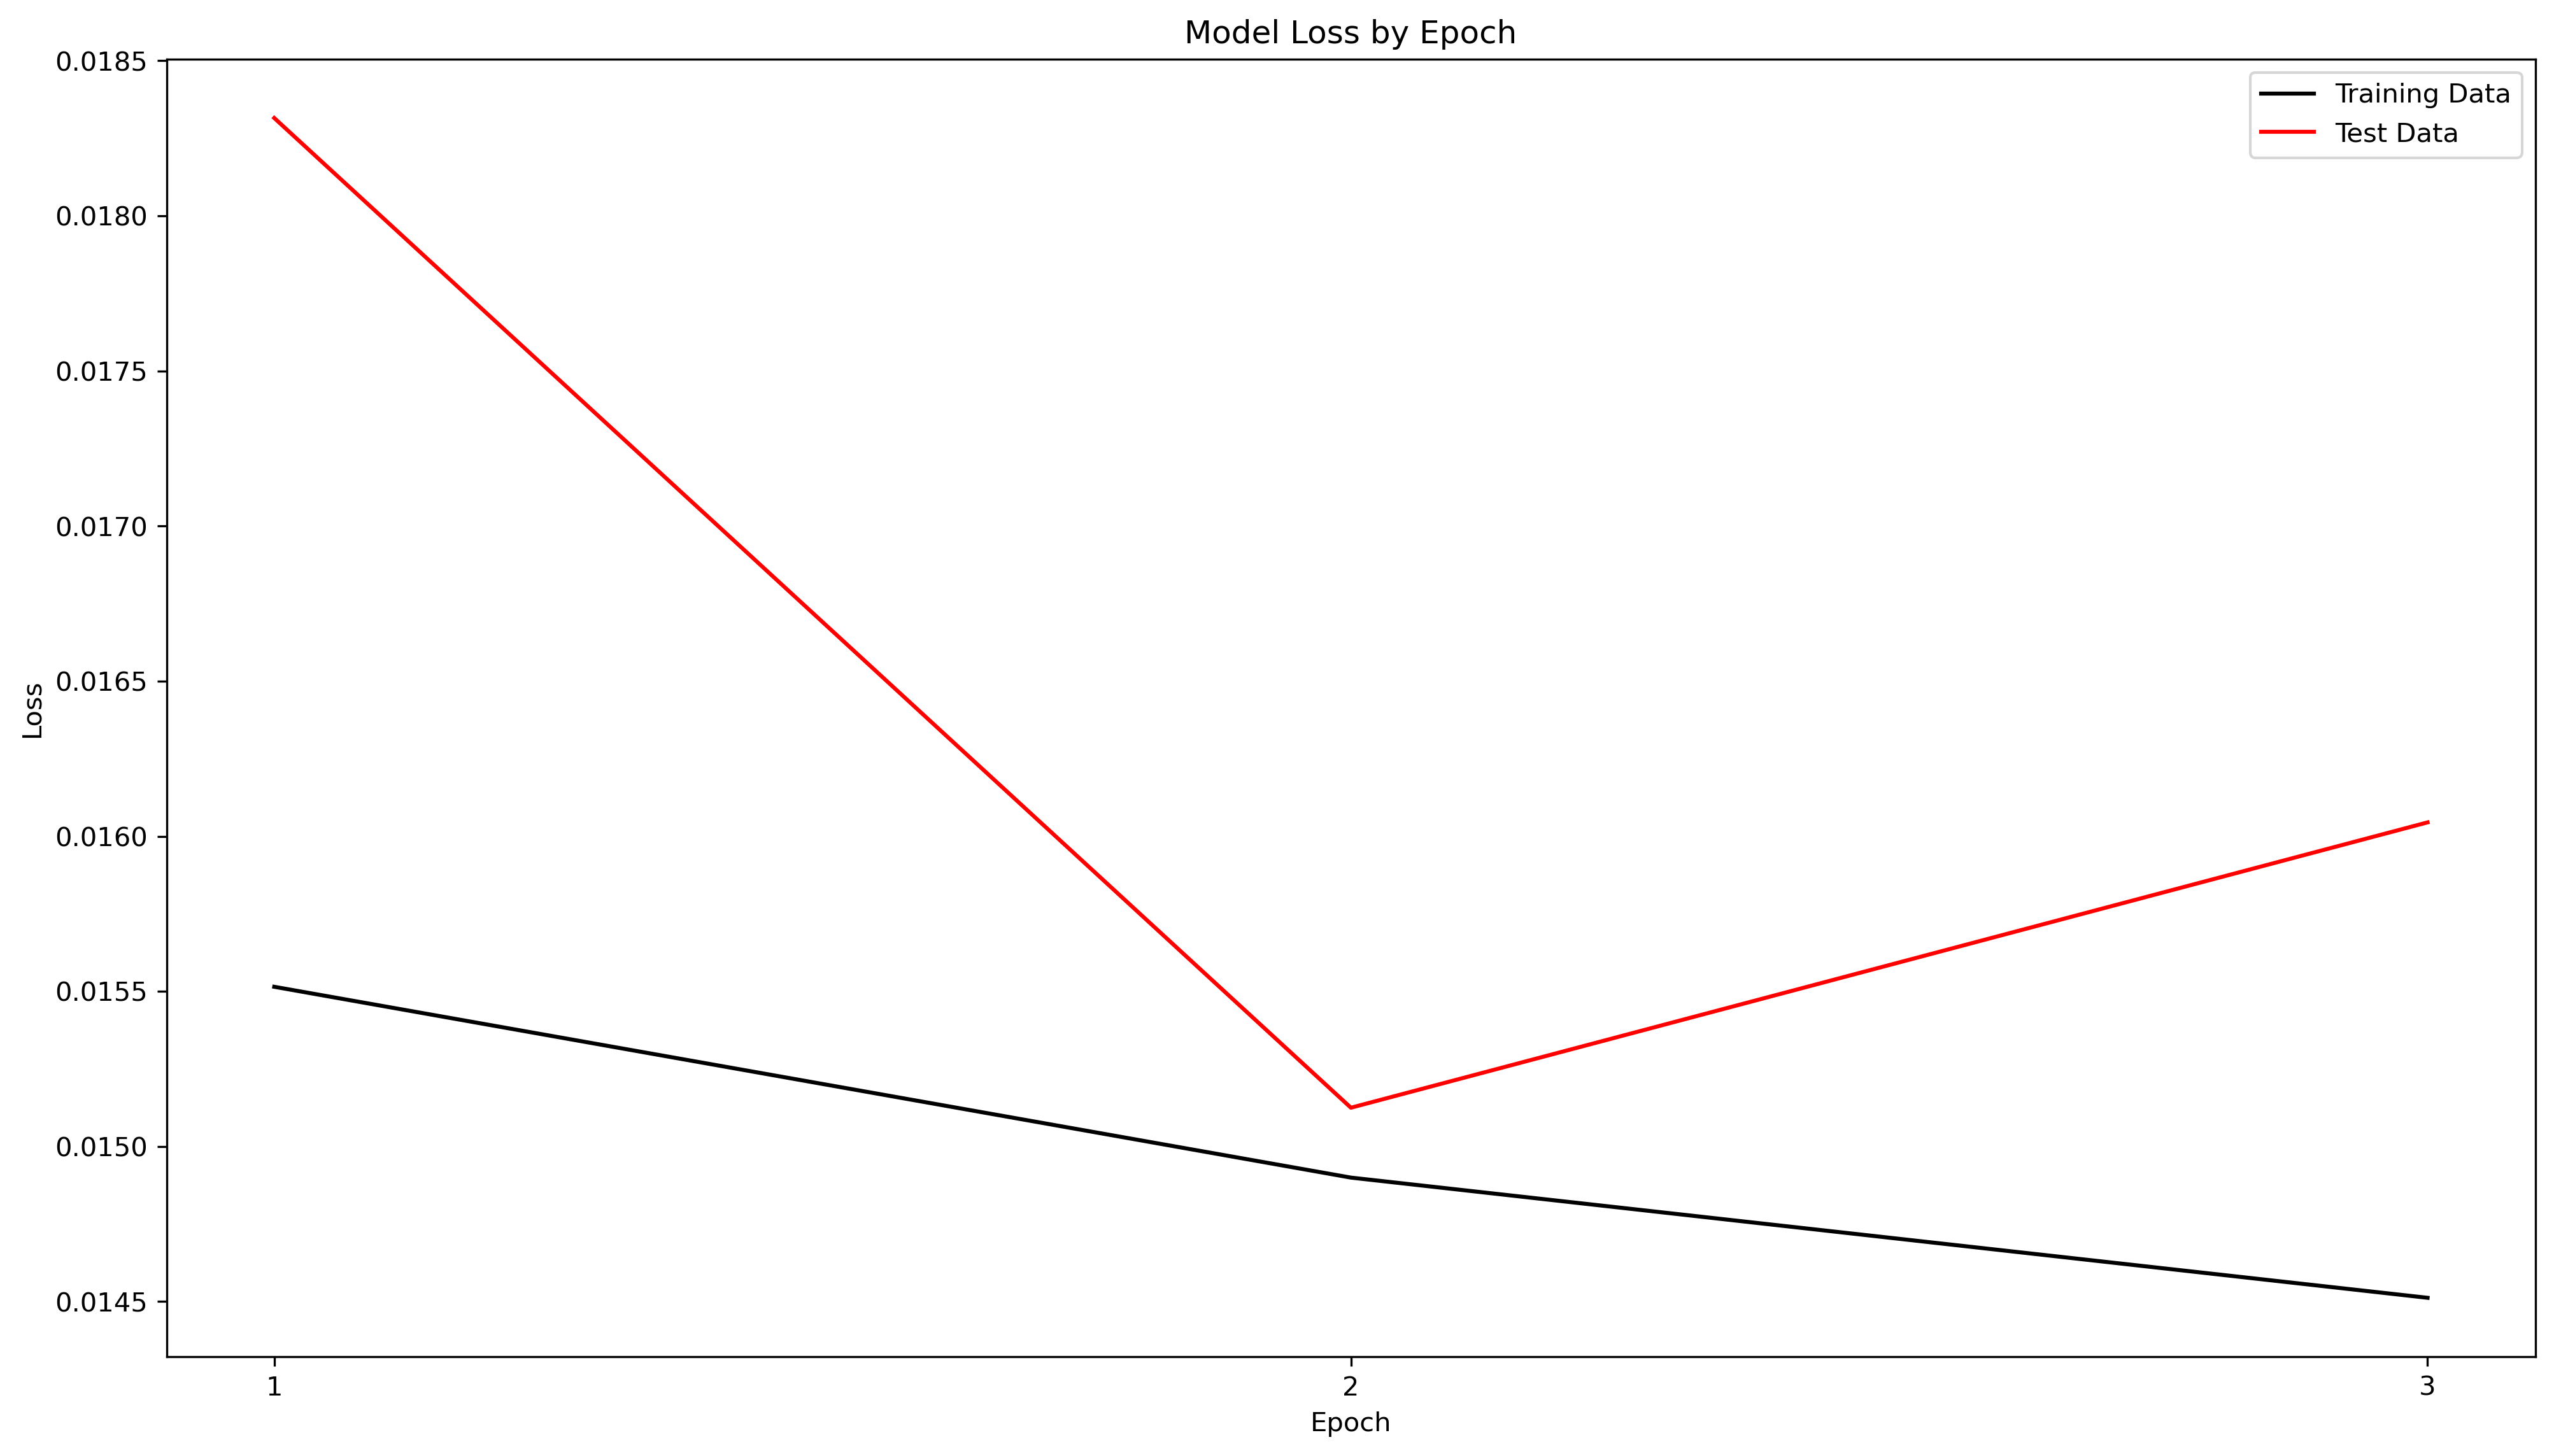

In [17]:
# Fit the Denoising autoencoder model to reconstruct original images
history = model.fit(X_train_noisy, X_train, epochs=3, batch_size=32, verbose=1, validation_data=(X_test_noisy, X_test))

# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss'])), labels=np.arange(1, len(history.history['loss'])+1))
plt.legend()

plt.show()

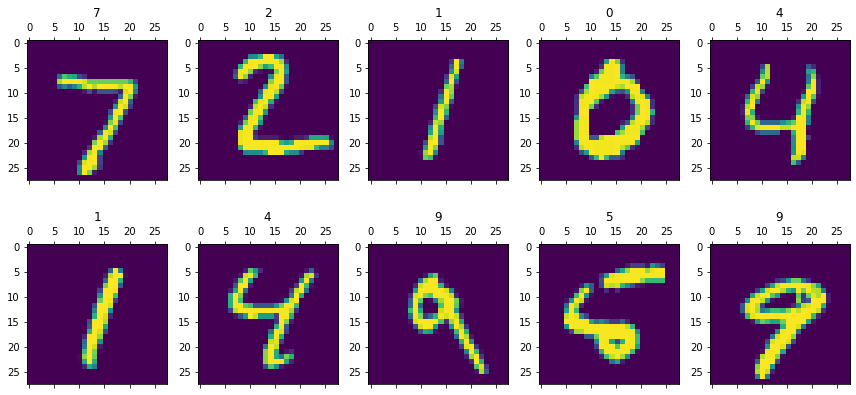

In [14]:
# Reshape back
X_test_back = X_test.reshape(10000, 28, 28)

# Display images of the first 10 digits
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(X_test_back[n])
        axs[i,j].set(title=y_test[n])
        n=n+1
plt.show() 

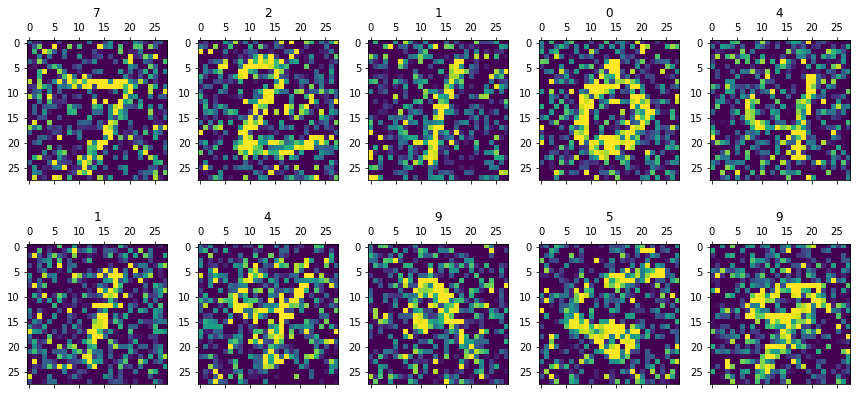

In [15]:
# Reshape back
X_test_noisy_reshaped = X_test_noisy.reshape(10000, 28, 28)

# Display images of the first 10 digits
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(X_test_noisy_reshaped[n])
        axs[i,j].set(title=y_test[n])
        n=n+1
plt.show() 

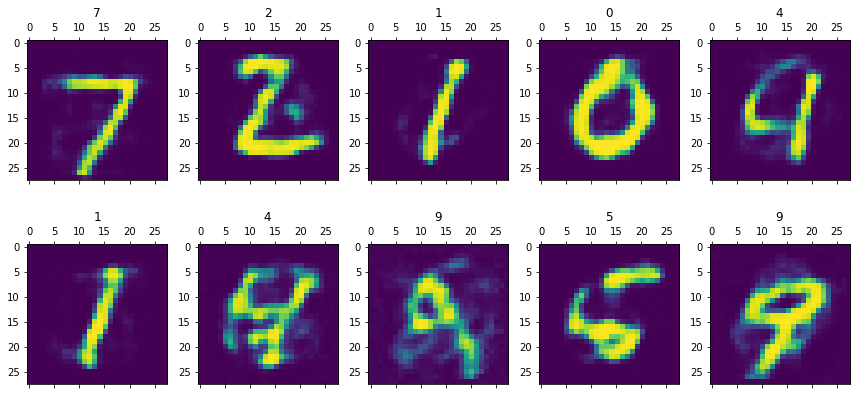

In [16]:
# Apply denoising model 
#X_train_denoised = model.predict(X_train_noisy).reshape(60000, 28, 28)
X_test_denoised = model.predict(X_test_noisy).reshape(10000, 28, 28)

# Display images of the first 10 digits
fig, axs = plt.subplots(2, 5, sharey=False, tight_layout=True, figsize=(12,6), facecolor='white')
n=0
for i in range(0,2):
    for j in range(0,5):
        axs[i,j].matshow(X_test_denoised[n])
        axs[i,j].set(title=y_test[n])
        n=n+1
plt.show() 